In [2]:
#Import Library
import pandas as pd
from sklearn import svm
from sklearn import preprocessing
from sklearn import tree
from sklearn.metrics import accuracy_score, recall_score,precision_score, confusion_matrix, roc_curve, auc
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
 

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import pydotplus
from IPython.display import Image
import matplotlib.pyplot as plt
import pylab as pl
import seaborn as sns
plt.rcParams['figure.figsize'] = (7,7) # Make the figures a bit bigger

import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation,BatchNormalization
from tensorflow.keras import utils
from tensorflow.keras import regularizers
from keras.models import Sequential    
from keras.wrappers.scikit_learn import KerasClassifier
from imblearn.under_sampling import RandomUnderSampler


In [3]:
# load data
df1 = pd.read_csv("./accepted_2007_to_2018Q4.csv")
df1.head()

# set id as index
df1.set_index('id', inplace = True)
df = df1[['loan_amnt', 'term', 'grade', 'annual_inc', 'verification_status', 'dti', 'delinq_2yrs',
        'fico_range_high','inq_last_6mths','open_acc','pub_rec','revol_bal',
        'revol_util','total_acc','avg_cur_bal','total_rev_hi_lim','acc_open_past_24mths','pct_tl_nvr_dlq','loan_status']]

# drop all rows with nan 
df.dropna(inplace = True)

# change predicting variables into 1 and 0
df = df[df['loan_status'].isin(['Fully Paid','Charged Off', 'Late (31-120 days)', 'Late (16-30 days)', 'Default'])]
df['loan_status'] = df['loan_status'].map({'Fully Paid':1,'Charged Off':0, 'Late (31-120 days)':0, 'Late (16-30 days)':0, 'Default':0})

# convert all categorical values into numerical values
obj_df = df.select_dtypes(include=['object']).copy()
for name in obj_df.columns:
    if name != 'home_ownership':
        df[name] = df[name].astype('category').cat.codes
        
# new dataset size
print('New dataset has',len(df),'rows, and',len(df.columns),'columns.')

"""## Prepare training and testing dataset"""

# Define features and target
X = df.loc[:, df.columns != 'loan_status']      # Features
y = df['loan_status']                           # Target

# Splitting the datasets into training and testing data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Output the train and test data size
print(f"Train and Test Size {len(X_train)}, {len(X_test)}")
print('New dataset has',len(df),'rows, and',len(df.columns),'columns.')

#balance
rus = RandomUnderSampler(random_state=0)
rus.fit(X, y)
X2, y2 = rus.fit_resample(X, y)
# Splitting the datasets into training and testing data.
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.3, random_state=0)

# Output the train and test data size
print(f"Train and Test Size {len(X_train2)}, {len(X_test2)}")
print('New dataset has',len(df),'rows, and',len(df.columns),'columns.')

New dataset has 1302276 rows, and 19 columns.
Train and Test Size 911593, 390683
New dataset has 1302276 rows, and 19 columns.
Train and Test Size 391228, 167670
New dataset has 1302276 rows, and 19 columns.


In [ ]:
def get_classification(predictions,threshold):
    classes = np.zeros_like(predictions)
    for i in range(len(classes)):
        if predictions[i] > threshold:
            classes[i] = 1
    return classes

In [ ]:
def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()

def svm_model(X_train, X_test, y_train, y_test, kernel_type, C, gamma, cv):
    # standardizing X
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train_transformed = scaler.transform(X_train)
    X_test_transformed = scaler.transform(X_test)
    
    # create model
    clf = svm.SVC(kernel=kernel_type, C=C,gamma=gamma)
    
    # cross validation
    cv_results = cross_validate(clf, X_train_transformed, y_train, cv=cv)
    scores = cv_results['test_score']
    print("train set with cross validation: %0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
    
    # fit model and do prediction
    clf.fit(X_train_transformed, y_train)
    accuracy = clf.score(X_test_transformed, y_test)
    y_pred = clf.predict(X_test_transformed)
    print(f'test set accuracy:{accuracy}')
     
    return y_pred

In [ ]:
# measure result score and draw pictures
def Measure(y_true, y_pred,method,number,thresholds = 0.5):
    if type(y_pred[0] == 'float32'):
        y_pred1 = get_classification(y_pred,thresholds)
    else:
        y_pred1 = y_pred
    accuracy=accuracy_score(y_true, y_pred1)
    precision=precision_score(y_true, y_pred1)
    recall=recall_score(y_true, y_pred1)
    tn, fp, fn, tp=confusion_matrix(np.ravel(y_true),y_pred1).ravel()
    matrix=confusion_matrix(np.ravel(y_true),y_pred1)
    (fpr, tpr, thresholds) = roc_curve(y_true,y_pred)
    area = auc(fpr,tpr)

    plt.figure(number,figsize=(10,8))
    pl.plot(fpr,tpr,label="Out-Sample ROC Curve with area = %1.2f"%area)
    pl.plot([0, 1], [0, 1], 'k') #This plots the random (equal probability line)
    pl.xlim([0.0, 1.0])
    pl.ylim([0.0, 1.0])
    pl.xlabel('False Positive Rate')
    pl.ylabel('True Positive Rate')
    pl.title(method+' ROC')
    pl.legend(loc="lower right")
    pl.show()
    print('tn',tn,'fp',fp,'fn',fn,'tp',tp)
    print('matrix',matrix,'accuracy',accuracy,'precision',precision,'recall',recall,'ROC',area)
    
    #plot confusion matrix
    plt.figure(number*3)
    ax = sns.heatmap(matrix, annot=True, cmap='Blues')
    ax.set_title('Confusion Matrix');
    ax.set_xlabel('Predicted Values')
    ax.set_ylabel('Actual Values ');
    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])
    ## Display the visualization of the Confusion Matrix.
    plt.show()
    return matrix,accuracy,precision,recall

In [ ]:
def nn_model(X_train, X_test, y_train, y_test, epochs = 5, batch_size=1): 
    
    # standardise X
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    # creat NN model using sequential
    model = Sequential()
    # first layer
    model.add(Dense(12, kernel_initializer='TruncatedNormal', input_shape=(len(X_train[0]),)))
    model.add(Activation('relu'))
    model.add(Dropout(0.15))
    # second layer
    model.add(Dense(4, kernel_initializer='TruncatedNormal'))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    # output layer
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
    optimizer='sgd',
    metrics=['accuracy'])
    # fit model
    model.fit(X_train, y_train,epochs=epochs, batch_size=batch_size, verbose=1)
    # prediction
    y_pred = model.predict(X_test)
    # get accuracy
    score = model.evaluate(X_test, y_test,verbose=1)
    print(score)
    return y_pred

In [ ]:
## Gridsearch for neural network
scaler = StandardScaler().fit(X_train2)
X_train3 = scaler.transform(X_train2)
y_train3 = y_train2
def create_model(init_mode='TruncatedNormal'):
    # define model
    model = Sequential()
    model.add(Dense(12, kernel_initializer=init_mode, activation='relu', input_shape=(len(X_train3[0]),))) 
    model.add(Dropout(0.15))
    model.add(Dense(4, kernel_initializer=init_mode, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    model.compile(loss='binary_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])
    return model


model_CV = KerasClassifier(build_fn=create_model, verbose=1)
# parameters combinations
batch_size = [1, 10, 100, 1000]
epochs = [1, 3, 5]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model_CV, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train3, y_train3)

# print results
print(f'Best Accuracy for {grid_result.best_score_} using {grid_result.best_params_}')
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f' mean={mean:.4}, std={stdev:.4} using {param}')

Epoch 1/5
39123/39123 [==============================] - 58s 1ms/step - loss: 0.6423 - accuracy: 0.6320
Epoch 2/5
39123/39123 [==============================] - 55s 1ms/step - loss: 0.6312 - accuracy: 0.6478
Epoch 3/5
39123/39123 [==============================] - 56s 1ms/step - loss: 0.6309 - accuracy: 0.6479
Epoch 4/5
39123/39123 [==============================] - 56s 1ms/step - loss: 0.6302 - accuracy: 0.6488
Epoch 5/5
39123/39123 [==============================] - 56s 1ms/step - loss: 0.6303 - accuracy: 0.6486
Best Accuracy for 0.6540150245030721 using {'batch_size': 10, 'epochs': 5}
 mean=0.652, std=0.001623 using {'batch_size': 1, 'epochs': 1}
 mean=0.65, std=0.003087 using {'batch_size': 1, 'epochs': 3}
 mean=0.653, std=0.0006976 using {'batch_size': 1, 'epochs': 5}
 mean=0.6522, std=0.0006293 using {'batch_size': 10, 'epochs': 1}
 mean=0.6537, std=0.0007082 using {'batch_size': 10, 'epochs': 3}
 mean=0.654, std=0.001138 using {'batch_size': 10, 'epochs': 5}
 mean=0.6163, std=0.

Epoch 1/5
39123/39123 [==============================] - 76s 2ms/step - loss: 0.6389 - accuracy: 0.6373
Epoch 2/5
39123/39123 [==============================] - 62s 2ms/step - loss: 0.6335 - accuracy: 0.6452
Epoch 3/5
39123/39123 [==============================] - 62s 2ms/step - loss: 0.6330 - accuracy: 0.6458
Epoch 4/5
39123/39123 [==============================] - 64s 2ms/step - loss: 0.6327 - accuracy: 0.6457
Epoch 5/5
5240/5240 [==============================] - 7s 1ms/step - loss: 0.6226 - accuracy: 0.6536
[0.6226099133491516, 0.6535635590553284]


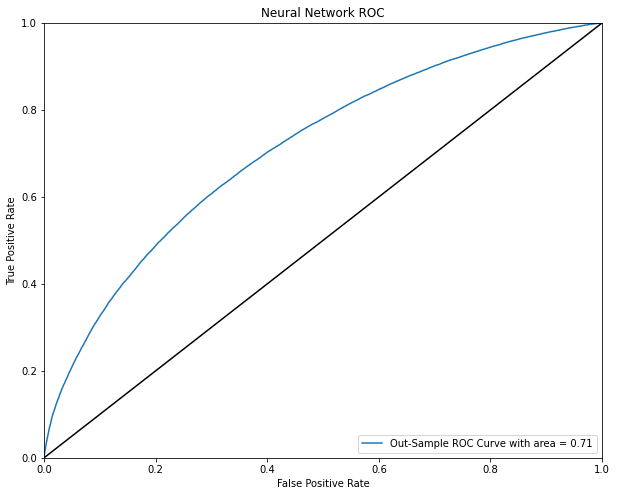

tn 58637 fp 24902 fn 33185 tp 50946
matrix [[58637 24902]
 [33185 50946]] accuracy 0.6535635474443848 precision 0.671685476215589 recall 0.6055556215901392 ROC 0.7124011267502783


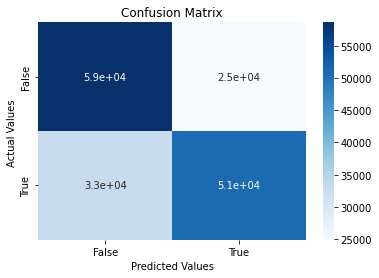

In [ ]:
# using best epochs and batch_size got through gridsearch
y_pred_nn4 = nn_model(X_train2, X_test2, y_train2, y_test2, epochs = 5, batch_size=10)
matrix_nn,accuracy_nn,precision_nn,recall_nn=Measure(y_test2, y_pred_nn4,'Neural Network',0,0.5)

train set with cross validation: 0.65 accuracy with a standard deviation of 0.00
test set accuracy:0.6551670309085232


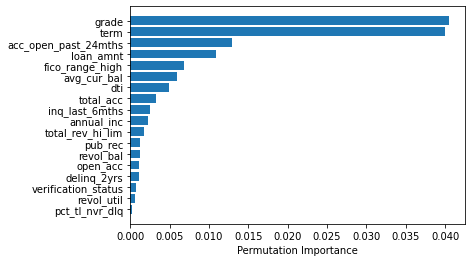

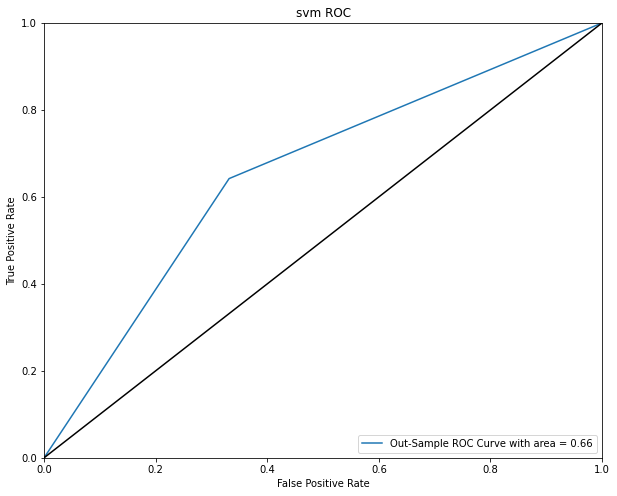

tn 4263 fp 2115 fn 2303 tp 4131
matrix [[4263 2115]
 [2303 4131]] accuracy 0.6551670309085232 precision 0.6613832853025937 recall 0.6420578178427107 ROC 0.6552245815460025


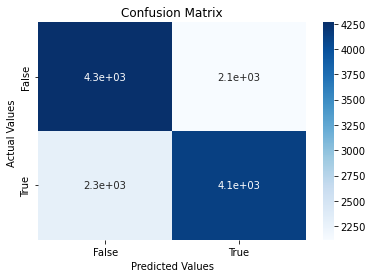

In [ ]:
# randomly select 100000 rows
df_svm = df.sample(n = 100000) 
# Define features and target
X_svm = df_svm.loc[:, df.columns != 'loan_status']               # Features
y_svm = df_svm['loan_status']                           # Target
#balance
rus = RandomUnderSampler(random_state=0)
rus.fit(X_svm, y_svm)
X_svm, y_svm = rus.fit_resample(X_svm, y_svm)
# Splitting the datasets into training and testing data.
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(X_svm, y_svm, test_size=0.3, random_state=0)
# predict using svm model and draw feature importance, ROC and confusion matrix
y_pred_svm = svm_model(X_train_svm, X_test_svm, y_train_svm, y_test_svm, 'rbf', 1, 'auto', 5)
matrix_svm,accuracy_svm,precision_svm,recall_svm=Measure(y_test_svm, y_pred_svm,'svm', 0, 0.5)